In [1]:
import numpy as np
import torch
import itertools
import matplotlib.pyplot as plt

from copy import deepcopy

# Neural Net with Backpropagation Implementation

In [2]:
class Sigmoid(object):
    def __init__(self):
        pass
    
    def forward(self, net):
        act = 1.0 / (1.0 + np.exp(-net))
        return act
    
    def backward(self, net):
        act = self.forward(net)
        return act*(1 - act)
    
    
class Tanh(object):
    def __init__(self):
        pass
    
    def forward(self, net):
        act = (2.0 / (1.0 + np.exp(-2*net)))-1
        return act
    
    def backward(self, net):
        act = self.forward(net)
        return 1-np.power(act,2)
    
    
class Heaviside(object):
    def __init__(self):
        pass
    
    def forward(self, net):
        act = np.array(net, copy = True)
        act[net>=0]=1
        act[net< 0]=0
        return act
        
    def backward(self, net):
        d_net = np.zeros_like(net)
        d_net[net==0]=np.nan
        return d_net
    
    
class Identity(object):
    def __init__(self):
        pass
    
    def forward(self, net):
        return net
    
    def backward(self, net):
        act = np.ones_like(net)
        return act
    
    
class ReLU(object):
    def __init__(self):
        pass
    
    def forward(self, net):
        act = np.maximum(0,net)
        return act
    
    def backward(self, net):
        d_net = np.array(net, copy = True)
        d_net[net<=0]=0
        d_net[net> 0]=1
        return d_net 
    
    
class BinaryCrossEntropy():
    def __init__(self):
        pass
    
    def forward(self, prediction, ground_truth):
        m = prediction.shape[0]
        cost_pos = np.dot(ground_truth.T, np.log(prediction)) 
        cost_neg = np.dot((1-ground_truth).T, np.log(1 - prediction))
        cost = -(1/m) * (cost_pos+cost_neg)
        return np.squeeze(cost)
    
    def backward(self, prediction, ground_truth):
        ground_truth = ground_truth.reshape(prediction.shape)
        dA = -(np.divide(ground_truth, prediction) - np.divide(1 - ground_truth, 1 - prediction))
        return dA
    
    
class MeanSquaredErrorLoss():
    def __init__(self):
        pass
    
    def forward(self, prediction, ground_truth):
        cost = np.power(prediction-ground_truth, 2).mean()
        return np.squeeze(cost)
    
    def backward(self, prediction, ground_truth):
        dA = 2*(prediction-ground_truth).mean()
        return dA
    
    
def convert_logits_into_class(probs, thresh=0.5):
    probs_ = np.copy(probs)
    probs_[probs_ >  thresh] = 1
    probs_[probs_ <= thresh] = 0
    return probs_


def get_accuracy_value(Y_hat, Y, thresh=0.5):
    Y_hat_ = convert_logits_into_class(Y_hat, thresh)
    return (Y_hat_ == Y).mean()

In [3]:
class Linear(object):
    # Simple feed forward layer
    def __init__(self, in_features, out_features, activation_func, seed=41, small_init=True):
        self.in_features = in_features
        self.out_features = out_features
        self.activation_func = activation_func
        np.random.seed(seed)
        self.bias = np.random.rand(self.out_features,1).astype(np.float32)
        self.weight = np.random.rand(self.out_features,self.in_features).astype(np.float32)
        if small_init:
            self.bias = self.bias*.1
            self.weight = self.weight*.1
        
    def forward(self, inputs):
        net = np.dot(inputs,self.weight.T)+self.bias.T
        act = self.activation_func().forward(net)
        self.net = net
        self.act = act
        return act
    
    def backward(self, d_prev, act_prev):
        d_prev = d_prev*self.activation_func().backward(self.net)
        m = d_prev.shape[0]
        self.d_weight = np.dot(d_prev.T, act_prev)/m
        self.d_bias = np.sum(d_prev, axis=0, keepdims=True).T/m
        d_prev = np.dot(d_prev, self.weight)
        return d_prev

In [4]:
class FeedForwardNetwork(object):
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
class BackwardPropagation(object):
    def __init__(self, network, loss_function, learning_rate):
        self.network = network
        self.loss_function = loss_function
        self.learning_rate = learning_rate
    
    def backward(self, x, prediction, ground_truth):
        layers = self.network.layers
        d_prev = self.loss_function.backward(prediction, ground_truth)
        for i, _ in reversed(list(enumerate(layers))):
            if i!= 0:
                d_prev = layers[i].backward(d_prev, layers[i-1].act)
            else:
                d_prev = layers[i].backward(d_prev, x)
        self._update()
                
    def _update(self):
        for layer in self.network.layers:
            layer.weight -= self.learning_rate*layer.d_weight
            layer.bias   -= self.learning_rate*layer.d_bias
            

class DataLoader(object):
    def __init__(self, data, target, batch_size, shuffle=True):
        self.data = data
        self.target = target
        self.batch_size = batch_size
        self.len_data = data.shape[0]
        self.shuffle = shuffle
        self.num_batches = int(np.floor(self.len_data/self.batch_size))
        
    def get(self):
        
        if self.shuffle:
            permutated_idx = np.random.choice(range(0, self.len_data), self.len_data, replace=False)
            permutated_data = self.data[permutated_idx]
            permutated_target = self.target[permutated_idx]
        else:   
            permutated_data = self.data
            permutated_target = self.target
            
        for i in range(self.num_batches):
            batch_num = i%self.num_batches
            start_idx = batch_num*self.batch_size
            end_idx   = min((batch_num+1)*self.batch_size, self.len_data)
            yield permutated_data[start_idx:end_idx], permutated_target[start_idx:end_idx]

# Proof of Concept

## Example 1

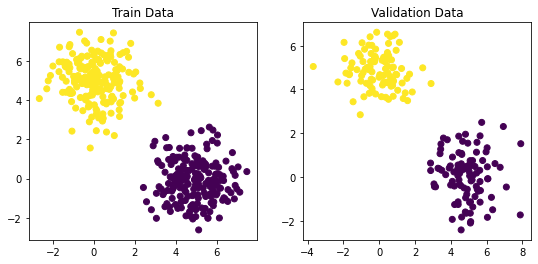

In [5]:
data_pos = np.random.multivariate_normal(mean=(0,5), cov=np.diag((1,1)), size=300)
target_pos = np.ones((300,1))
data_neg = np.random.multivariate_normal(mean=(5,0), cov=np.diag((1,1)), size=300)
target_neg = np.zeros((300,1))
data = np.concatenate([data_pos, data_neg], axis=0)
target = np.concatenate([target_pos, target_neg], axis=0)

train_idx = np.random.choice(range(0,600), 400, replace=False)
valid_idx = [i for i in range(600) if i not in train_idx]
train_data = data[train_idx]
train_target = target[train_idx]
valid_data = data[valid_idx]
valid_target = target[valid_idx]

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(9,4)
axes[0].scatter(train_data[:,0], train_data[:,1], c=train_target)
axes[0].set_title('Train Data')
axes[1].scatter(valid_data[:,0], valid_data[:,1], c=valid_target)
axes[1].set_title('Validation Data')
plt.show()

In [6]:
layers = [Linear(2,1, Sigmoid)]
net = FeedForwardNetwork(layers)
loss_function = BinaryCrossEntropy()
back_prop = BackwardPropagation(net, loss_function, 0.1)
acc_list = []
epochs=5
print_every = 1

dl = DataLoader(data, target, 64)

print("[#epoch, #mini-batch]")
for epoch in range(epochs):
    running_loss = 0.0
    for i, (batch_data, batch_target) in enumerate(dl.get()):
        batch_pred = net.forward(batch_data)
        acc_train = get_accuracy_value(batch_pred, batch_target)
        loss_train = loss_function.forward(batch_pred, batch_target)
        running_loss+=loss_train

        eval_net = deepcopy(net)
        valid_pred = eval_net.forward(valid_data)
        acc_valid = get_accuracy_value(valid_pred, valid_target)

        back_prop.backward(batch_data, batch_pred, batch_target)

        if i%print_every==print_every-1:
            print(f'[{epoch+1:2d}, {i+1:4d}], train accuracy: {acc_train:.2f}, validation accuracy: {acc_valid:.2f}')
        
eval_net = deepcopy(net)
valid_pred = eval_net.forward(valid_data)
valid_pred_classes = convert_logits_into_class(valid_pred)
acc_valid = get_accuracy_value(valid_pred, valid_target)

[#epoch, #mini-batch]
[ 1,    1], train accuracy: 0.56, validation accuracy: 0.62
[ 1,    2], train accuracy: 1.00, validation accuracy: 1.00
[ 1,    3], train accuracy: 1.00, validation accuracy: 1.00
[ 1,    4], train accuracy: 1.00, validation accuracy: 1.00
[ 1,    5], train accuracy: 1.00, validation accuracy: 1.00
[ 1,    6], train accuracy: 1.00, validation accuracy: 1.00
[ 1,    7], train accuracy: 1.00, validation accuracy: 1.00
[ 1,    8], train accuracy: 1.00, validation accuracy: 1.00
[ 1,    9], train accuracy: 1.00, validation accuracy: 1.00
[ 2,    1], train accuracy: 1.00, validation accuracy: 1.00
[ 2,    2], train accuracy: 1.00, validation accuracy: 1.00
[ 2,    3], train accuracy: 1.00, validation accuracy: 1.00
[ 2,    4], train accuracy: 1.00, validation accuracy: 1.00
[ 2,    5], train accuracy: 1.00, validation accuracy: 1.00
[ 2,    6], train accuracy: 1.00, validation accuracy: 1.00
[ 2,    7], train accuracy: 1.00, validation accuracy: 1.00
[ 2,    8], train 

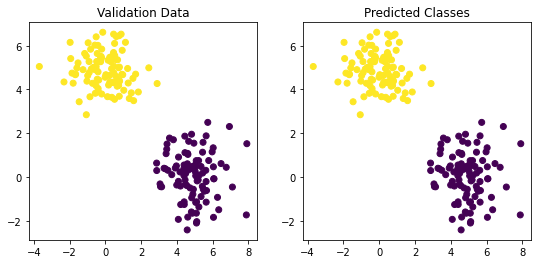

In [7]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(9,4)
axes[0].scatter(valid_data[:,0], valid_data[:,1], c=valid_target)
axes[0].set_title('Validation Data')
axes[1].scatter(valid_data[:,0], valid_data[:,1], c=valid_pred_classes)
axes[1].set_title('Predicted Classes')
plt.show()

## Example 2

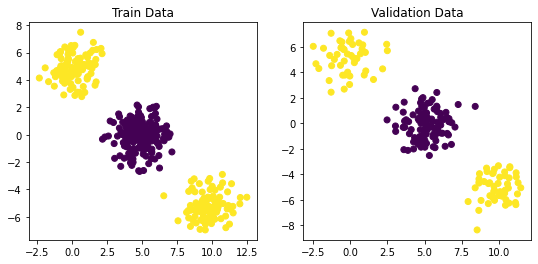

In [8]:
data_pos1 = np.random.multivariate_normal(mean=(0,5), cov=np.diag((1,1)), size=150)
data_pos2 = np.random.multivariate_normal(mean=(10,-5), cov=np.diag((1,1)), size=150)
target_pos = np.ones((300,1))
data_neg = np.random.multivariate_normal(mean=(5,0), cov=np.diag((1,1)), size=300)
target_neg = np.zeros((300,1))
data = np.concatenate([data_pos1, data_pos2, data_neg], axis=0)
target = np.concatenate([target_pos, target_neg], axis=0)

train_idx = np.random.choice(range(0,600), 400, replace=False)
valid_idx = [i for i in range(600) if i not in train_idx]
train_data = data[train_idx]
train_target = target[train_idx]
valid_data = data[valid_idx]
valid_target = target[valid_idx]

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(9,4)
axes[0].scatter(train_data[:,0], train_data[:,1], c=train_target)
axes[0].set_title('Train Data')
axes[1].scatter(valid_data[:,0], valid_data[:,1], c=valid_target)
axes[1].set_title('Validation Data')
plt.show()

In [9]:
layers = [Linear(2,4, ReLU), Linear(4,1, Sigmoid)]
net = FeedForwardNetwork(layers)
back_prop = BackwardPropagation(net, BinaryCrossEntropy(), 0.1)
acc_list = []
epochs = 50
print_every = 10

dl = DataLoader(data, target, 16)

for epoch in range(epochs):
    for i, (batch_data, batch_target) in enumerate(dl.get()):
        batch_pred = net.forward(batch_data)
        acc_train = get_accuracy_value(batch_pred, batch_target)
        loss_train = loss_function.forward(batch_pred, batch_target)

        eval_net = deepcopy(net)
        valid_pred = eval_net.forward(valid_data)
        acc_valid = get_accuracy_value(valid_pred, valid_target)
        back_prop.backward(batch_data, batch_pred, batch_target)


        if i%print_every==print_every-1:
            print(f'[{epoch+1:2d}, {i+1:4d}], train accuracy: {acc_train:.2f}, validation accuracy: {acc_valid:.2f}')
        
eval_net = deepcopy(net)
valid_pred = eval_net.forward(valid_data)
valid_pred_classes = convert_logits_into_class(valid_pred)
acc_valid = get_accuracy_value(valid_pred, valid_target)

[ 1,   10], train accuracy: 0.56, validation accuracy: 0.48
[ 1,   20], train accuracy: 0.88, validation accuracy: 0.74
[ 1,   30], train accuracy: 0.56, validation accuracy: 0.69
[ 2,   10], train accuracy: 0.69, validation accuracy: 0.70
[ 2,   20], train accuracy: 0.69, validation accuracy: 0.73
[ 2,   30], train accuracy: 0.88, validation accuracy: 0.74
[ 3,   10], train accuracy: 0.62, validation accuracy: 0.74
[ 3,   20], train accuracy: 0.56, validation accuracy: 0.74
[ 3,   30], train accuracy: 0.81, validation accuracy: 0.74
[ 4,   10], train accuracy: 0.88, validation accuracy: 0.74
[ 4,   20], train accuracy: 0.88, validation accuracy: 0.74
[ 4,   30], train accuracy: 0.81, validation accuracy: 0.74
[ 5,   10], train accuracy: 0.69, validation accuracy: 0.74
[ 5,   20], train accuracy: 0.81, validation accuracy: 0.74
[ 5,   30], train accuracy: 0.81, validation accuracy: 0.74
[ 6,   10], train accuracy: 1.00, validation accuracy: 0.92
[ 6,   20], train accuracy: 0.88, valida

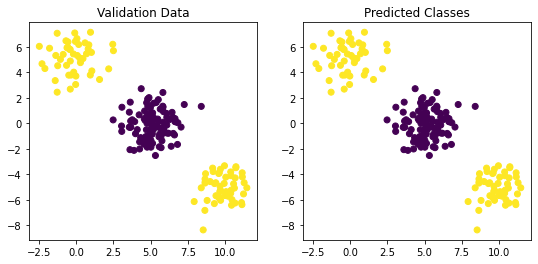

In [10]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(9,4)
axes[0].scatter(valid_data[:,0], valid_data[:,1], c=valid_target)
axes[0].set_title('Validation Data')
axes[1].scatter(valid_data[:,0], valid_data[:,1], c=valid_pred_classes)
axes[1].set_title('Predicted Classes')
plt.show()

## Example 3

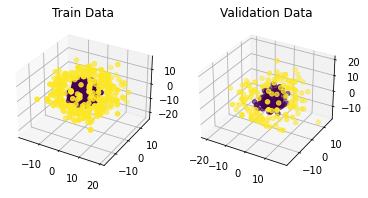

In [11]:
while True:
    data = np.random.multivariate_normal(mean=(0,0,0), cov=np.diag((30,30,30)), size=2000)
    dist_data = np.sqrt(np.power(data, 2).sum(axis=1))
    if (dist_data>=10).sum()>=600:
        candidates = data[dist_data>=10]
        pos_idx = np.random.choice(range(len(candidates)), 600)
        data_pos = candidates[pos_idx]
        target_pos = target_pos = np.ones((600,1))
        break
        
while True:
    data = np.random.multivariate_normal(mean=(0,0,0), cov=np.diag((10,10,10)), size=2000)
    dist_data = np.sqrt(np.power(data, 2).sum(axis=1))
    if (dist_data<=8).sum()>=600:
        candidates = data[dist_data<=8]
        pos_idx = np.random.choice(range(len(candidates)), 600)
        data_neg = candidates[pos_idx]
        target_neg= np.zeros((600,1))
        break
        
data = np.concatenate([data_pos, data_neg], axis=0)
target = np.concatenate([target_pos, target_neg], axis=0)

train_idx = np.random.choice(range(0,1200), 900, replace=False)
valid_idx = [i for i in range(1200) if i not in train_idx]
train_data = data[train_idx]
train_target = target[train_idx]
valid_data = data[valid_idx]
valid_target = target[valid_idx]


fig = plt.figure()
ax1 = fig.add_subplot(1 ,2 ,1 , projection='3d')
ax1.scatter(train_data[:,0], train_data[:,1], train_data[:,2], c=train_target)
ax1.set_title('Train Data')
ax2 = fig.add_subplot(1 ,2 ,2 , projection='3d')
ax2.scatter(valid_data[:,0], valid_data[:,1], valid_data[:,2], c=valid_target)
ax2.set_title('Validation Data')
plt.show()

In [12]:
layers = [Linear(3,8, ReLU), Linear(8,1, Sigmoid)]
net = FeedForwardNetwork(layers)
back_prop = BackwardPropagation(net, BinaryCrossEntropy(), 0.1)
acc_list = []
epochs = 5
print_every = 5

dl = DataLoader(data, target, 16)

for epoch in range(epochs):
    for i, (batch_data, batch_target) in enumerate(dl.get()):
        batch_pred = net.forward(batch_data)
        acc_train = get_accuracy_value(batch_pred, batch_target)
        loss_train = loss_function.forward(batch_pred, batch_target)

        eval_net = deepcopy(net)
        valid_pred = eval_net.forward(valid_data)
        acc_valid = get_accuracy_value(valid_pred, valid_target)

        back_prop.backward(batch_data, batch_pred, batch_target)

        if i%print_every==print_every-1 or i==epochs-1:
            print(f'[{epoch+1:2d}, {i+1:4d}], train accuracy: {acc_train:.2f}, validation accuracy: {acc_valid:.2f}')

eval_net = deepcopy(net)
valid_pred = eval_net.forward(valid_data)
valid_pred_classes = convert_logits_into_class(valid_pred)
acc_valid = get_accuracy_value(valid_pred, valid_target)
plt.show()

[ 1,    5], train accuracy: 0.50, validation accuracy: 0.57
[ 1,   10], train accuracy: 0.62, validation accuracy: 0.60
[ 1,   15], train accuracy: 0.56, validation accuracy: 0.59
[ 1,   20], train accuracy: 0.50, validation accuracy: 0.62
[ 1,   25], train accuracy: 0.81, validation accuracy: 0.63
[ 1,   30], train accuracy: 0.44, validation accuracy: 0.60
[ 1,   35], train accuracy: 0.69, validation accuracy: 0.61
[ 1,   40], train accuracy: 0.69, validation accuracy: 0.63
[ 1,   45], train accuracy: 0.75, validation accuracy: 0.62
[ 1,   50], train accuracy: 0.75, validation accuracy: 0.63
[ 1,   55], train accuracy: 0.75, validation accuracy: 0.63
[ 1,   60], train accuracy: 0.56, validation accuracy: 0.62
[ 1,   65], train accuracy: 0.75, validation accuracy: 0.63
[ 1,   70], train accuracy: 0.69, validation accuracy: 0.63
[ 1,   75], train accuracy: 0.56, validation accuracy: 0.66
[ 2,    5], train accuracy: 0.56, validation accuracy: 0.69
[ 2,   10], train accuracy: 0.69, valida

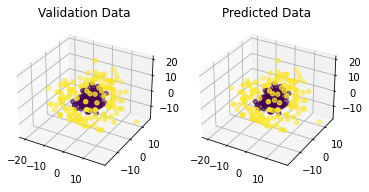

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(1 ,2 ,1 , projection='3d')
ax1.scatter(valid_data[:,0], valid_data[:,1], valid_data[:,2], c=valid_target)
ax1.set_title('Validation Data')
ax2 = fig.add_subplot(1 ,2 ,2 , projection='3d')
ax2.scatter(valid_data[:,0], valid_data[:,1], valid_data[:,2], c=valid_pred_classes)
ax2.set_title('Predicted Data')
plt.show()

# Parity 3 Problem

# Data

In [14]:
def generate_party(n):
    data = list(itertools.product([False, True], repeat=n))
    data = np.array(data, dtype=np.float32)
    target = np.sum(data, keepdims=True, axis=1)%2
    return data, target

def augment_data(data, order):
    aug_data = np.copy(data)
    len_data = data.shape[0]
    num_features = data.shape[1]
    enum_cols = range(num_features)
    for i in range(2,3+1):
        comb = itertools.combinations(enum_cols, i)
        for s in comb: 
            prod_data = np.ones((len_data, ))
            for c in s:
                prod_data = prod_data*data[:,c]
            aug_data = np.concatenate([aug_data, prod_data.reshape(-1,1)], axis=1)
    return aug_data

p3_data, p3_target = generate_party(3)
p3_data_aug = augment_data(p3_data, 3)

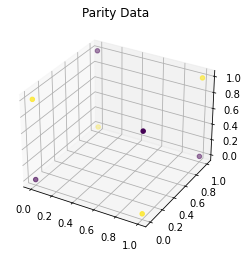

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(1 ,1 ,1 , projection='3d')
ax1.scatter(p3_data[:,0], p3_data[:,1], p3_data[:,2], c=p3_target)
ax1.set_title('Parity Data')
plt.show()

# Functional-Link Network

In [16]:
layers = [Linear(7,1, Sigmoid, small_init=False)]
fnl_net = FeedForwardNetwork(layers)
loss_fnl = BinaryCrossEntropy()
back_prop = BackwardPropagation(fnl_net, loss_fnl, 0.9)
acc_list = []
epochs = 5000
print_every = 500

fnl_acc_list = []
fnl_loss_list = []

dl = DataLoader(p3_data_aug, p3_target, 8)

for epoch in range(epochs):
    for i, (batch_data, batch_target) in enumerate(dl.get()):
        pred = fnl_net.forward(batch_data)
        if np.any(pred>1):
            print(pred)
        acc = get_accuracy_value(pred, batch_target)
        loss = loss_function.forward(pred, batch_target)

        fnl_acc_list.append(acc)
        fnl_loss_list.append(loss)

        back_prop.backward(batch_data, pred, batch_target)
        
        if epoch%print_every==print_every-1:
            print(f'[{epoch+1:2d}, {i+1:4d}], train accuracy: {acc:.3f}')

[500,    1], train accuracy: 1.000
[1000,    1], train accuracy: 1.000
[1500,    1], train accuracy: 1.000
[2000,    1], train accuracy: 1.000
[2500,    1], train accuracy: 1.000
[3000,    1], train accuracy: 1.000
[3500,    1], train accuracy: 1.000
[4000,    1], train accuracy: 1.000
[4500,    1], train accuracy: 1.000
[5000,    1], train accuracy: 1.000


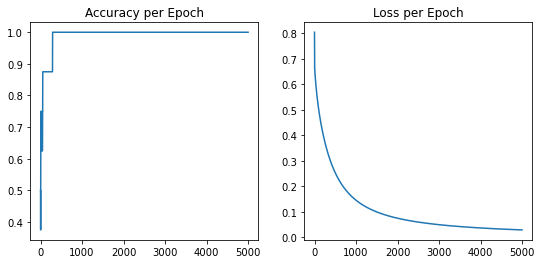

In [17]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(9,4)
axes[0].plot(fnl_acc_list)
axes[0].set_title('Accuracy per Epoch')
axes[1].plot(fnl_loss_list)
axes[1].set_title('Loss per Epoch')
plt.show()

# Generalized-Delta Rule Netwrok

In [18]:
layers = [Linear(3,3, Sigmoid, small_init=False), Linear(3,1, Sigmoid, small_init=False)]
gdr_net = FeedForwardNetwork(layers)
loss_func = BinaryCrossEntropy()
back_prop = BackwardPropagation(gdr_net, loss_func, 0.9)
acc_list = []
epochs = 5000
batch_size = 8
print_every = 500

gdr_acc_list = []
gdr_loss_list = []

dl = DataLoader(p3_data, p3_target, batch_size, shuffle=False)

for epoch in range(epochs):
    for i, (batch_data, batch_target) in enumerate(dl.get()):
        pred = gdr_net.forward(batch_data)
        acc = get_accuracy_value(pred, batch_target)
        loss = loss_func.forward(pred, batch_target)
        
        gdr_acc_list.append(acc)
        gdr_loss_list.append(loss)

        eval_gdr_net = deepcopy(gdr_net)
        valid_pred = eval_gdr_net.forward(p3_data)
        acc_valid = get_accuracy_value(valid_pred, p3_target)

        back_prop.backward(batch_data, pred, batch_target)

        if epoch%print_every==print_every-1:
            print(f'[{epoch+1:2d}, {i+1:4d}], train accuracy: {acc:.3f}, valid accuracy: {acc_valid:.3f}')

[500,    1], train accuracy: 0.750, valid accuracy: 0.750
[1000,    1], train accuracy: 0.625, valid accuracy: 0.625
[1500,    1], train accuracy: 0.750, valid accuracy: 0.750
[2000,    1], train accuracy: 1.000, valid accuracy: 1.000
[2500,    1], train accuracy: 1.000, valid accuracy: 1.000
[3000,    1], train accuracy: 1.000, valid accuracy: 1.000
[3500,    1], train accuracy: 1.000, valid accuracy: 1.000
[4000,    1], train accuracy: 1.000, valid accuracy: 1.000
[4500,    1], train accuracy: 1.000, valid accuracy: 1.000
[5000,    1], train accuracy: 1.000, valid accuracy: 1.000


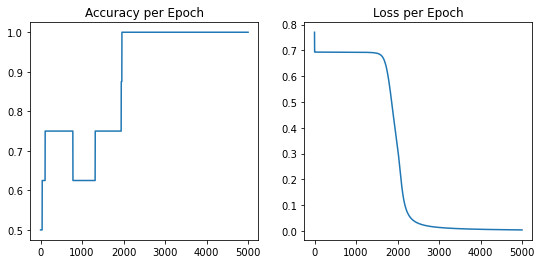

In [19]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(9,4)
axes[0].plot(gdr_acc_list)
axes[0].set_title('Accuracy per Epoch')
axes[1].plot(gdr_loss_list)
axes[1].set_title('Loss per Epoch')
plt.show()

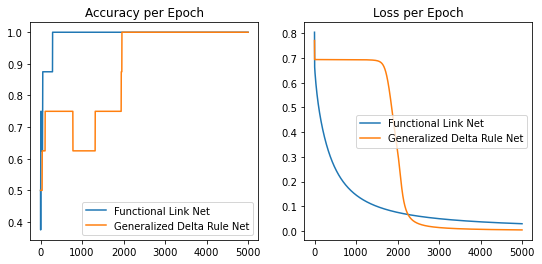

In [20]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(9,4)
axes[0].plot(fnl_acc_list, label='Functional Link Net')
axes[0].plot(gdr_acc_list, label='Generalized Delta Rule Net')
axes[0].set_title('Accuracy per Epoch')
axes[0].legend()
axes[1].plot(fnl_loss_list, label='Functional Link Net')
axes[1].plot(gdr_loss_list, label='Generalized Delta Rule Net')
axes[1].set_title('Loss per Epoch')
axes[1].legend()
plt.show()